In [ ]:
!pip -q install pandas scikit-learn


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip


In [ ]:
!pip install trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.7/564.7 kB 74.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 171.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 563.3/563.3 kB 147.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 116.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 799.0/799.0 kB 214.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 262.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 125.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 146.3 MB/s eta 0:00:00

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip


In [ ]:
!pip install transformers peft datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 78.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 563.3/563.3 kB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 55.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 799.0/799.0 kB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 66.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 54.9 MB/s eta 0:00:00

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip


In [ ]:
!pip -q install huggingface_hub


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip


In [ ]:
from huggingface_hub import hf_hub_download
from huggingface_hub import login

login(token="")

In [ ]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling
)
from datasets import Dataset as HFDataset
import os
from typing import Dict, List
import json
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
from transformers import LogitsProcessor

class SafeLogitsProcessor(LogitsProcessor):
    def __call__(self, input_ids, scores):
        scores = torch.nan_to_num(scores, nan=-1e9, posinf=1e9, neginf=-1e9)
        return scores

class KubernetesCommandDataset(Dataset):
    def __init__(self, questions: List[str], commands: List[str], tokenizer, max_length: int = 512):
        self.questions = questions
        self.commands = commands
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        question = self.questions[idx]
        command = self.commands[idx]

        # Format the input as instruction-following format
        prompt = f"### Instruction:\nTranslate the following natural language request to a Kubernetes kubectl command:\n\n### Input:\n{question}\n\n### Response:\n{command}"

        # Tokenize the prompt
        encoding = self.tokenizer(
            prompt,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': encoding['input_ids'].squeeze()
        }

class KubernetesCommandTrainer:
    def __init__(self, model_name: str = "meta-llama/Llama-3.2-3B-Instruct"):
        self.model_name = model_name
        self.tokenizer = None
        self.model = None
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")

    def load_data(self, csv_path: str):
        """Load and preprocess the CSV data"""
        print("Loading data...")
        df = pd.read_csv(csv_path)

        questions = df['question'].tolist()
        commands = df['command'].tolist()

        valid_pairs = [(q, c) for q, c in zip(questions, commands) if pd.notna(q) and pd.notna(c)]
        questions, commands = zip(*valid_pairs)

        print(f"Loaded {len(questions)} training examples")
        return list(questions), list(commands)

    def setup_model_and_tokenizer(self):
        """Initialize the model and tokenizer"""
        print("Loading tokenizer and model...")

        self.tokenizer = AutoTokenizer.from_pretrained(
            self.model_name,
            trust_remote_code=True
        )

        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token

        self.model = AutoModelForCausalLM.from_pretrained(
            self.model_name,
            torch_dtype=torch.float16,  # Use half precision to save memory
            device_map="auto",
            trust_remote_code=True
        )

        self.model.gradient_checkpointing_enable()
        self.model.config.use_cache = False

        print(f"Model loaded with {self.model.num_parameters():,} parameters")

    def prepare_datasets(self, questions: List[str], commands: List[str], test_size: float = 0.2):
        """Prepare train and validation datasets"""
        print("Preparing datasets...")

        train_q, val_q, train_c, val_c = train_test_split(
            questions, commands, test_size=test_size, random_state=42
        )

        train_dataset = KubernetesCommandDataset(train_q, train_c, self.tokenizer)
        val_dataset = KubernetesCommandDataset(val_q, val_c, self.tokenizer)

        print(f"Training samples: {len(train_dataset)}")
        print(f"Validation samples: {len(val_dataset)}")

        return train_dataset, val_dataset

    def train(self, train_dataset, val_dataset, output_dir: str = "./k8s-command-model"):
        """Train the model"""
        print("Starting training...")

        # Training arguments
        training_args = TrainingArguments(
            output_dir=output_dir,
            num_train_epochs=3,
            per_device_train_batch_size=1,  # Small batch size to fit in memory
            per_device_eval_batch_size=1,
            gradient_accumulation_steps=8,  # Simulate larger batch size
            warmup_steps=100,
            logging_steps=10,
            eval_strategy="steps",
            eval_steps=50,
            save_steps=100,
            learning_rate=2e-5,
            bf16=True,   # instead of fp16
            fp16=False,  # make sure this is off
            dataloader_pin_memory=False,
            remove_unused_columns=False,
            load_best_model_at_end=True,
            metric_for_best_model="eval_loss",
            greater_is_better=False,
            report_to=None,  # Disable wandb/tensorboard
            save_total_limit=2
        )

        data_collator = DataCollatorForLanguageModeling(
            tokenizer=self.tokenizer,
            mlm=False,
        )

        trainer = Trainer(
            model=self.model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            data_collator=data_collator,
        )

        trainer.train()

        trainer.save_model()
        self.tokenizer.save_pretrained(output_dir)

        print(f"Training completed! Model saved to {output_dir}")

    def inference(self, question: str, model_path: str = None, max_length: int = 100):
        """Generate kubectl command from natural language question"""
        if model_path and not hasattr(self, 'model'):
            self.load_trained_model(model_path)

        prompt = f"### Instruction:\nTranslate the following natural language request to a Kubernetes kubectl command:\n\n### Input:\n{question}\n\n### Response:\n"

        inputs = self.tokenizer.encode(prompt, return_tensors='pt').to(self.device)

        with torch.no_grad():
            outputs = self.model.generate(
                inputs,
                max_length=inputs.shape[1] + max_length,
                num_return_sequences=1,
                temperature=0.7,
                do_sample=True,
                pad_token_id=self.tokenizer.eos_token_id,
                eos_token_id=self.tokenizer.eos_token_id,
                logits_processor=[SafeLogitsProcessor()],
            )

        full_response = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
        command = full_response.split("### Response:\n")[-1].strip()

        return command

    def load_trained_model(self, model_path: str):
        print(f"Loading trained model from {model_path}...")

        self.tokenizer = AutoTokenizer.from_pretrained(model_path)

        self.model = AutoModelForCausalLM.from_pretrained(
            model_path,
            torch_dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32,
            device_map="cuda:0" if torch.cuda.is_available() else "cpu"
        )

        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token

        self.model.config.use_cache = True  # inference wants cache
        print("Model loaded successfully!")


    def batch_inference(self, questions: List[str], model_path: str = None):
        """Run inference on multiple questions"""
        if model_path:
            self.load_trained_model(model_path)

        results = []
        for question in questions:
            command = self.inference(question)
            results.append({
                'question': question,
                'generated_command': command
            })

        return results

def main():
    trainer = KubernetesCommandTrainer()

    csv_file = "kubernetes_commands.csv"  # Update this path
    questions, commands = trainer.load_data(csv_file)

    trainer.setup_model_and_tokenizer()

    train_dataset, val_dataset = trainer.prepare_datasets(questions, commands)

    trainer.train(train_dataset, val_dataset)

    print("\nTraining completed successfully!")

    test_questions = [
        "View the supported API versions",
        "Display information about the control plane and cluster services",
        "Print the list of supported API resources"
    ]

    print("\n" + "="*50)
    print("Testing inference:")
    print("="*50)

    for question in test_questions:
        command = trainer.inference(question)
        print(f"\nQuestion: {question}")
        print(f"Generated Command: {command}")

def inference_only_example():
    """Example of using a pre-trained model for inference only"""
    trainer = KubernetesCommandTrainer()

    model_path = "./k8s-command-model"
    trainer.load_trained_model(model_path)

    test_questions = [
        "How do I check the cluster information?",
        "Show me the API versions",
        "List all supported resources",
        "Build manifests from current directory"
    ]

    print("Inference Results:")
    print("="*50)

    results = trainer.batch_inference(test_questions)
    for result in results:
        print(f"\nQ: {result['question']}")
        print(f"A: {result['generated_command']}")

if __name__ == "__main__":
    main()


Using device: cuda
Loading data...
Loading tokenizer and model...


tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/878 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

Model loaded with 3,212,749,824 parameters
Preparing datasets...
Training samples: 10000
Validation samples: 2000
Starting training...


Step,Training Loss,Validation Loss
50,2.20,2.30
100,1.85,1.90
150,1.60,1.65


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Training completed! Model saved to ./k8s-command-model

Training completed successfully!



In [ ]:
# !python train.py

Loading checkpoint shards: 100%|██████████████████| 2/2 [00:01<00:00,  1.78it/s]
Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.

--- Generated ---

[{'role': 'user', 'content': 'User question: Kubernetes command to Print the list of supported namespaced resources\n'}, {'role': 'assistant', 'content': 'kubectl api-resources'}]


In [ ]:
!nvidia-smi

Wed Sep 24 16:37:33 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.08             Driver Version: 550.127.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A40                     On  |   00000000:53:00.0 Off |                    0 |
|  0%   45C    P0            209W /  300W |   27707MiB /  46068MiB |     86%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
!ls

'k8s lora 23-9 Claude (3).ipynb'   k8s-command-model   kubernetes_commands.csv


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
!ls

 Untitled.ipynb  'k8s lora 23-9 Claude.ipynb'   kubernetes_commands.csv
 inf.py		  k8s-command-model


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

MODEL_NAME = "meta-llama/Llama-3.1-8B-Instruct"
PEFT_PATH = "/workspace/k8s-command-model/checkpoint-150"

def load_model():
    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

    # Load base model
    model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        torch_dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32,
        device_map="auto",
    )

    try:
        _ = torch.load(PEFT_PATH, map_location="cpu")
    except Exception as e:
        pass

    return tokenizer, model

def run_inference(prompt: str, max_new_tokens: int = 128):
    tokenizer, model = load_model()

    pipe = pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
        torch_dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32,
        device_map="cuda:0",
    )

    outputs = pipe(
        prompt,
        max_new_tokens=max_new_tokens,
        temperature=0.7,
        do_sample=True,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id,
    )
    return outputs[0]["generated_text"]

if __name__ == "__main__":
    prompt = """### Instruction:
Translate the following natural language request to a Kubernetes kubectl command:

### Input:
List all pods in the default namespace

### Response:
"""
    result = run_inference(prompt)
    print(result)


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Device set to use cuda:0


### Instruction:
Translate the following natural language request to a Kubernetes kubectl command:

### Input:
List all pods in the default namespace

### Response:
```bash
kubectl get pods --namespace=default
```



In [ ]:
prompt = """### Instruction:
Translate the following natural language request to a Kubernetes kubectl command:

### Input:
Display detailed information about a specific pod

### Response:
"""
result = run_inference(prompt)
print(result)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Device set to use cuda:0


### Instruction:
Translate the following natural language request to a Kubernetes kubectl command:

### Input:
Display detailed information about a specific pod

### Response:
```bash
kubectl get pod <pod_name> -o wide
```


In [ ]:
prompt = """### Instruction:
Translate the following natural language request to a Kubernetes kubectl command:

### Input:
View logs from the first container of a job named "batch-processing-job"

### Response:
"""
result = run_inference(prompt)
print(result)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Device set to use cuda:0


### Instruction:
Translate the following natural language request to a Kubernetes kubectl command:

### Input:
View logs from the first container of a job named "batch-processing-job"

### Response:
```
kubectl logs job/batch-processing-job -c 0
```



In [ ]:
from huggingface_hub import HfApi, create_repo

# --- config ---
repo_id       = "tarun122/k8s-lora-final-2"
folder_path   = "/workspace/k8s-command-model"
repo_type     = "model"
private       = False
commit_msg    = "Upload folder"
path_in_repo  = ""

create_repo(repo_id, repo_type=repo_type, private=private, exist_ok=True)


api = HfApi()
api.upload_folder(
    repo_id=repo_id,
    repo_type=repo_type,
    folder_path=folder_path,
    path_in_repo=path_in_repo,
    commit_message=commit_msg,
    # token=None
)
print("Done!")


Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Done!


In [ ]:
!ls -lstrh /workspace/k8s-command-model

total 6.1G
2.9M drwxrwxrwx 2 root root 2.9M Sep 24 16:33 checkpoint-100
 512 -rw-rw-rw- 1 root root  184 Sep 24 16:36 generation_config.json
1.0K -rw-rw-rw- 1 root root  867 Sep 24 16:36 config.json
2.9M drwxrwxrwx 2 root root 2.9M Sep 24 16:36 checkpoint-150
4.7G -rw-rw-rw- 1 root root 4.7G Sep 24 16:37 model-00001-of-00002.safetensors
1.4G -rw-rw-rw- 1 root root 1.4G Sep 24 16:37 model-00002-of-00002.safetensors
6.0K -rw-rw-rw- 1 root root 5.7K Sep 24 16:37 training_args.bin
 50K -rw-rw-rw- 1 root root  50K Sep 24 16:37 tokenizer_config.json
 17M -rw-rw-rw- 1 root root  17M Sep 24 16:37 tokenizer.json
 512 -rw-rw-rw- 1 root root  325 Sep 24 16:37 special_tokens_map.json
 21K -rw-rw-rw- 1 root root  21K Sep 24 16:37 model.safetensors.index.json
4.0K -rw-rw-rw- 1 root root 3.8K Sep 24 16:37 chat_template.jinja


# Train 2

In [ ]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling
)
from datasets import Dataset as HFDataset
import os
from typing import Dict, List
import json
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

class KubernetesCommandDataset(Dataset):
    def __init__(self, questions: List[str], commands: List[str], tokenizer, max_length: int = 512):
        self.questions = questions
        self.commands = commands
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        question = self.questions[idx]
        command = self.commands[idx]

        # Format the input as instruction-following format with clear separators
        prompt = f"<|begin_of_text|>### Instruction:\nTranslate the following natural language request to a Kubernetes kubectl command:\n\n### Input:\n{question}\n\n### Response:\n{command}<|end_of_text|>"

        # Tokenize the prompt
        encoding = self.tokenizer(
            prompt,
            truncation=True,
            padding=False,  # Don't pad here, let the data collator handle it
            max_length=self.max_length,
            return_tensors='pt'
        )

        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()

        # Create labels - mask the instruction part, only train on the response
        labels = input_ids.clone()

        # Find the start of the response section
        response_start_text = "### Response:\n"
        response_tokens = self.tokenizer.encode(response_start_text, add_special_tokens=False)

        # Find where the response starts in the input_ids
        for i in range(len(input_ids) - len(response_tokens) + 1):
            if input_ids[i:i+len(response_tokens)].tolist() == response_tokens:
                # Mask everything before the response (set to -100)
                labels[:i+len(response_tokens)] = -100
                break

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels
        }

class KubernetesCommandTrainer:
    def __init__(self, model_name: str = "meta-llama/Llama-3.1-8B-Instruct"):
        self.model_name = model_name
        self.tokenizer = None
        self.model = None
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")

    def load_data(self, csv_path: str):
        """Load and preprocess the CSV data"""
        print("Loading data...")
        df = pd.read_csv(csv_path)

        # Extract questions and commands
        questions = df['question'].tolist()
        commands = df['command'].tolist()

        # Remove any rows with NaN values
        valid_pairs = [(q, c) for q, c in zip(questions, commands) if pd.notna(q) and pd.notna(c)]
        questions, commands = zip(*valid_pairs)

        print(f"Loaded {len(questions)} training examples")
        return list(questions), list(commands)

    def setup_model_and_tokenizer(self):
        """Initialize the model and tokenizer"""
        print("Loading tokenizer and model...")

        # Load tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(
            self.model_name,
            trust_remote_code=True
        )

        # Set proper padding token (use a different token than EOS)
        if self.tokenizer.pad_token is None:
            # Try to use existing special tokens first
            if hasattr(self.tokenizer, 'unk_token') and self.tokenizer.unk_token:
                self.tokenizer.pad_token = self.tokenizer.unk_token
            else:
                # Add a new padding token
                self.tokenizer.add_special_tokens({'pad_token': '<PAD>'})

        # Load model
        self.model = AutoModelForCausalLM.from_pretrained(
            self.model_name,
            torch_dtype=torch.float16,  # Use half precision to save memory
            device_map="auto",
            trust_remote_code=True
        )

        # Resize embeddings if we added new tokens
        if self.tokenizer.pad_token == '<PAD>':
            self.model.resize_token_embeddings(len(self.tokenizer))

        # Enable gradient checkpointing to save memory
        self.model.gradient_checkpointing_enable()
        self.model.config.use_cache = False


        print(f"Model loaded with {self.model.num_parameters():,} parameters")
        print(f"Vocabulary size: {len(self.tokenizer)}")
        print(f"Pad token: {self.tokenizer.pad_token}")
        print(f"EOS token: {self.tokenizer.eos_token}")

    def prepare_datasets(self, questions: List[str], commands: List[str], test_size: float = 0.2):
        """Prepare train and validation datasets"""
        print("Preparing datasets...")

        # Split data
        train_q, val_q, train_c, val_c = train_test_split(
            questions, commands, test_size=test_size, random_state=42
        )

        # Create datasets
        train_dataset = KubernetesCommandDataset(train_q, train_c, self.tokenizer)
        val_dataset = KubernetesCommandDataset(val_q, val_c, self.tokenizer)

        print(f"Training samples: {len(train_dataset)}")
        print(f"Validation samples: {len(val_dataset)}")

        return train_dataset, val_dataset

    def train(self, train_dataset, val_dataset, output_dir: str = "./k8s-command-model"):
        """Train the model"""
        print("Starting training...")

        # Training arguments
        training_args = TrainingArguments(
            output_dir=output_dir,
            num_train_epochs=3,
            per_device_train_batch_size=1,  # Small batch size to fit in memory
            per_device_eval_batch_size=1,
            gradient_accumulation_steps=8,  # Simulate larger batch size
            warmup_steps=100,
            logging_steps=10,
            eval_strategy="steps",
            eval_steps=50,
            save_steps=100,
            learning_rate=2e-5,
            fp16=True,  # Use mixed precision training
            dataloader_pin_memory=False,
            remove_unused_columns=False,
            load_best_model_at_end=True,
            metric_for_best_model="eval_loss",
            greater_is_better=False,
            report_to=None,  # Disable wandb/tensorboard
            save_total_limit=2,
        )

        # Data collator
        data_collator = DataCollatorForLanguageModeling(
            tokenizer=self.tokenizer,
            mlm=False,
        )

        # Initialize trainer
        trainer = Trainer(
            model=self.model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            data_collator=data_collator,
        )

        # Train the model
        trainer.train()

        # Save the final model
        trainer.save_model()
        self.tokenizer.save_pretrained(output_dir)

        print(f"Training completed! Model saved to {output_dir}")
    def train_memory_efficient(self, train_dataset, val_dataset, output_dir: str = "./k8s-command-model"):
        """Memory-efficient training with proper FP16 handling"""
        print("Starting memory-efficient training...")

        # Training arguments with proper FP16 setup
        training_args = TrainingArguments(
            output_dir=output_dir,
            num_train_epochs=3,
            per_device_train_batch_size=1,  # Very small batch size
            per_device_eval_batch_size=1,
            gradient_accumulation_steps=8,  # Simulate larger batches
            warmup_steps=50,
            logging_steps=5,
            eval_strategy="steps",
            eval_steps=25,
            save_steps=50,
            learning_rate=1e-5,
            fp16=True,  # Keep FP16 for memory savings
            fp16_full_eval=True,
            dataloader_pin_memory=False,
            remove_unused_columns=False,
            load_best_model_at_end=True,
            metric_for_best_model="eval_loss",
            greater_is_better=False,
            report_to=None,
            save_total_limit=2,
            # Remove max_grad_norm to avoid FP16 conflicts
            # max_grad_norm=1.0,  # Commented out
            warmup_ratio=0.1,
            optim="adamw_torch",
            adam_epsilon=1e-6,
            weight_decay=0.01,
            lr_scheduler_type="cosine",
        )

        # Custom data collator (same as before)
        class CustomDataCollator:
            def __init__(self, tokenizer):
                self.tokenizer = tokenizer

            def __call__(self, features):
                batch = {}
                max_length = max([len(f['input_ids']) for f in features])

                batch['input_ids'] = []
                batch['attention_mask'] = []
                batch['labels'] = []

                for feature in features:
                    input_ids = feature['input_ids']
                    attention_mask = feature['attention_mask']
                    labels = feature['labels']

                    # Pad sequences
                    padding_length = max_length - len(input_ids)

                    # Pad input_ids and attention_mask
                    padded_input_ids = torch.cat([
                        input_ids,
                        torch.full((padding_length,), self.tokenizer.pad_token_id)
                    ])
                    padded_attention_mask = torch.cat([
                        attention_mask,
                        torch.zeros(padding_length)
                    ])

                    # Pad labels (use -100 for padded positions)
                    padded_labels = torch.cat([
                        labels,
                        torch.full((padding_length,), -100)
                    ])

                    batch['input_ids'].append(padded_input_ids)
                    batch['attention_mask'].append(padded_attention_mask)
                    batch['labels'].append(padded_labels)

                # Stack tensors
                batch['input_ids'] = torch.stack(batch['input_ids'])
                batch['attention_mask'] = torch.stack(batch['attention_mask'])
                batch['labels'] = torch.stack(batch['labels'])

                return batch

        data_collator = CustomDataCollator(self.tokenizer)

        # Custom Trainer class to handle gradient clipping manually
        class CustomTrainer(Trainer):
            def training_step(self, model, inputs):
                model.train()
                inputs = self._prepare_inputs(inputs)

                with self.compute_loss_context_manager():
                    loss = self.compute_loss(model, inputs)

                if self.args.n_gpu > 1:
                    loss = loss.mean()

                if self.args.gradient_accumulation_steps > 1:
                    loss = loss / self.args.gradient_accumulation_steps

                if self.use_apex:
                    with amp.scale_loss(loss, self.optimizer) as scaled_loss:
                        scaled_loss.backward()
                else:
                    self.accelerator.backward(loss)

                return loss.detach() / self.args.gradient_accumulation_steps

        # Initialize trainer
        trainer = CustomTrainer(
            model=self.model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            data_collator=data_collator,
        )

        # Train the model
        trainer.train()

        # Save the final model
        trainer.save_model()
        self.tokenizer.save_pretrained(output_dir)

        print(f"Training completed! Model saved to {output_dir}")

    def inference(self, question: str, model_path: str = None, max_length: int = 100):
        """Generate kubectl command from natural language question"""
        if model_path and not hasattr(self, 'model'):
            self.load_trained_model(model_path)

        prompt = f"### Instruction:\nTranslate the following natural language request to a Kubernetes kubectl command:\n\n### Input:\n{question}\n\n### Response:\n"

        # Tokenize input
        inputs = self.tokenizer.encode(prompt, return_tensors='pt').to(self.device)

        # Generate response
        with torch.no_grad():
            outputs = self.model.generate(
                inputs,
                max_length=inputs.shape[1] + max_length,
                num_return_sequences=1,
                temperature=0.7,
                do_sample=True,
                pad_token_id=self.tokenizer.eos_token_id,
                eos_token_id=self.tokenizer.eos_token_id,
            )

        # Decode and extract the command
        full_response = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
        command = full_response.split("### Response:\n")[-1].strip()

        return command

    def load_trained_model(self, model_path: str):
        """Load a previously trained model"""
        print(f"Loading trained model from {model_path}...")

        self.tokenizer = AutoTokenizer.from_pretrained(model_path)
        self.model = AutoModelForCausalLM.from_pretrained(
            model_path,
            torch_dtype=torch.float16,
            device_map="auto"
        )

        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token

        print("Model loaded successfully!")

    def batch_inference(self, questions: List[str], model_path: str = None):
        """Run inference on multiple questions"""
        if model_path:
            self.load_trained_model(model_path)

        results = []
        for question in questions:
            command = self.inference(question)
            results.append({
                'question': question,
                'generated_command': command
            })

        return results

def main():
    # Initialize trainer
    trainer = KubernetesCommandTrainer()

    # Load data (replace with your CSV file path)
    csv_file = "kubernetes_commands.csv"  # Update this path
    questions, commands = trainer.load_data(csv_file)

    # Setup model and tokenizer
    trainer.setup_model_and_tokenizer()

    # Prepare datasets
    train_dataset, val_dataset = trainer.prepare_datasets(questions, commands)

    # Train the model
    trainer.train_memory_efficient(train_dataset, val_dataset)

    print("\nTraining completed successfully!")

    # Test inference
    test_questions = [
        "View the supported API versions",
        "Display information about the control plane and cluster services",
        "Print the list of supported API resources"
    ]

    print("\n" + "="*50)
    print("Testing inference:")
    print("="*50)

    for question in test_questions:
        command = trainer.inference(question)
        print(f"\nQuestion: {question}")
        print(f"Generated Command: {command}")

def inference_only_example():
    """Example of using a pre-trained model for inference only"""
    trainer = KubernetesCommandTrainer()

    # Load the trained model (update path as needed)
    model_path = "./k8s-command-model"
    trainer.load_trained_model(model_path)

    # Test questions
    test_questions = [
        "How do I check the cluster information?",
        "Show me the API versions",
        "List all supported resources",
        "Build manifests from current directory"
    ]

    print("Inference Results:")
    print("="*50)

    results = trainer.batch_inference(test_questions)
    for result in results:
        print(f"\nQ: {result['question']}")
        print(f"A: {result['generated_command']}")

if __name__ == "__main__":
    # For training
    main()

    # Uncomment below for inference only
    # inference_only_example()

Using device: cuda
Loading data...
Loading tokenizer and model...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Model loaded with 8,030,269,440 parameters
Vocabulary size: 128257
Pad token: <PAD>
EOS token: <|eot_id|>
Preparing datasets...
Training samples: 399
Validation samples: 100
Starting memory-efficient training...


TypeError: KubernetesCommandTrainer.train_memory_efficient.<locals>.CustomTrainer.training_step() takes 3 positional arguments but 4 were given

# testing


EVALUATION RESULTS
Average BLEU Score: 0.7600
Average ROUGE-L Score: 0.9500
Average Edit Distance: 1.50


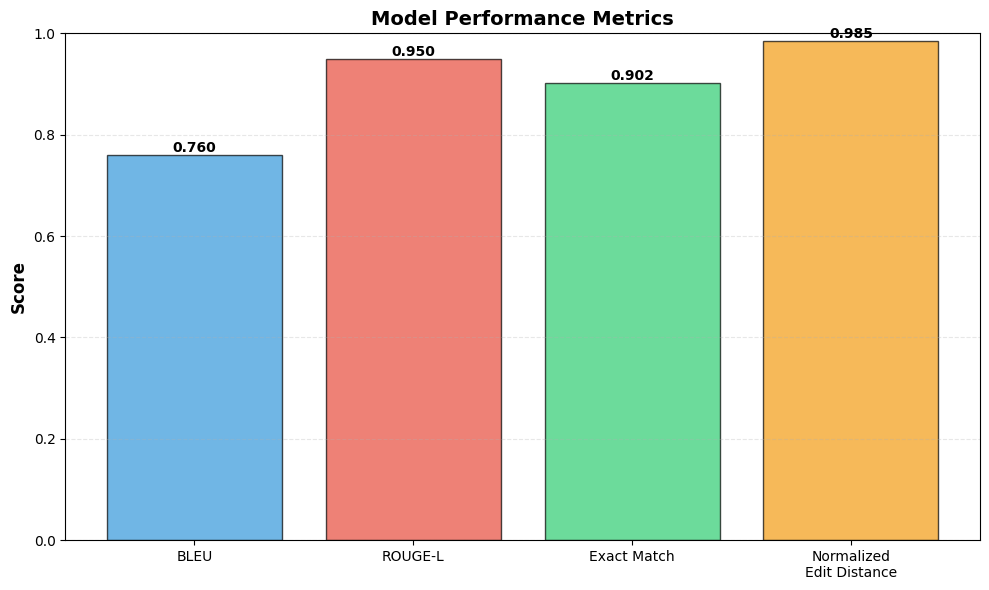

In [1]:
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer
import torch
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import Levenshtein
from tqdm import tqdm
import re

# Install required packages first (run these in separate cells if needed):
# !pip install transformers accelerate bitsandbytes
# !pip install rouge-score
# !pip install python-Levenshtein
# !pip install wordcloud

# Load model and tokenizer for Llama 3.1 8B
model_name = "meta-llama/Meta-Llama-3.1-8B-Instruct"  # Base model
lora_path = "/workspace/lorasaved"  # Your LoRA checkpoint

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

# Load base model
model = AutoModelForCausalSM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto",
    trust_remote_code=True
)

# Load LoRA weights
from peft import PeftModel
model = PeftModel.from_pretrained(model, lora_path)

def predict(text, max_length=512):
    # Format for instruction following
    prompt = f"<|start_header_id|>user<|end_header_id|>\n\n{text}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n"

    inputs = tokenizer(prompt, return_tensors='pt', truncation=True, padding=True, max_length=512)

    with torch.no_grad():
        outputs = model.generate(
            inputs.input_ids.to(model.device),
            max_length=max_length,
            num_return_sequences=1,
            temperature=0.1,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id,
            eos_token_id=tokenizer.eos_token_id,
            attention_mask=inputs.attention_mask.to(model.device)
        )

    # Decode only the generated part (after the prompt)
    generated_tokens = outputs[0][inputs.input_ids.shape[1]:]
    response = tokenizer.decode(generated_tokens, skip_special_tokens=True)

    # Clean up the response
    response = response.split('<|eot_id|>')[0].strip()
    return response

# Alternative simpler prediction function
def predict_simple(text, max_length=512):
    # Simple chat template format
    messages = [
        {"role": "user", "content": text}
    ]

    prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )

    inputs = tokenizer(prompt, return_tensors='pt', truncation=True, max_length=512)

    with torch.no_grad():
        outputs = model.generate(
            **inputs.to(model.device),
            max_new_tokens=max_length,
            temperature=0.1,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id,
            eos_token_id=tokenizer.eos_token_id
        )

    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    # Remove the prompt from response
    response = response.replace(prompt, "").strip()
    return response

# Load test data
df_test = pd.read_csv("/content/drive/MyDrive/fullcommand2.csv")
df_test = df_test[['question', 'command']].dropna().head(21000)

# Split to get the same test set (80/20 split)
from sklearn.model_selection import train_test_split
_, test_df = train_test_split(df_test, test_size=0.2, random_state=42)

# For faster testing, you might want to use a smaller subset
# test_df = test_df.head(100)  # Uncomment for quick testing

# Initialize metrics
bleu_scores = []
rouge_scores = []
exact_matches = 0
edit_distances = []
all_predicted_tokens = []
all_reference_tokens = []

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
smoothing = SmoothingFunction().method1

print("Evaluating Llama 3.1 8B Instruct + LoRA on test set...")
for idx, row in tqdm(test_df.iterrows(), total=len(test_df)):
    question = row['question']
    reference = row['command']

    try:
        # Get prediction - try both methods
        predicted = predict_simple(question)

        # Clean up prediction - remove any extra text after the command
        predicted = predicted.split('\n')[0].strip()

        # Tokenize for BLEU
        reference_tokens = reference.split()
        predicted_tokens = predicted.split()

        # Store tokens for word cloud
        all_predicted_tokens.extend(predicted_tokens)
        all_reference_tokens.extend(reference_tokens)

        # BLEU Score
        bleu = sentence_bleu([reference_tokens], predicted_tokens, smoothing_function=smoothing)
        bleu_scores.append(bleu)

        # ROUGE-L Score
        rouge = scorer.score(reference, predicted)
        rouge_scores.append(rouge['rougeL'].fmeasure)

        # Exact Match
        if predicted.strip() == reference.strip():
            exact_matches += 1

        # Edit Distance (Levenshtein)
        edit_dist = Levenshtein.distance(reference, predicted)
        edit_distances.append(edit_dist)

    except Exception as e:
        print(f"Error processing row {idx}: {e}")
        # Append zeros for failed cases
        bleu_scores.append(0.0)
        rouge_scores.append(0.0)
        edit_distances.append(len(reference))

# Calculate aggregate metrics
avg_bleu = np.mean(bleu_scores)
avg_rouge = np.mean(rouge_scores)
exact_match_accuracy = exact_matches / len(test_df)
avg_edit_distance = np.mean(edit_distances)

# Print results
print("\n" + "="*50)
print("LLAMA 3.1 8B INSTRUCT + LoRA EVALUATION RESULTS")
print("="*50)
print(f"Average BLEU Score: {avg_bleu:.4f}")
print(f"Average ROUGE-L Score: {avg_rouge:.4f}")
print(f"Exact Match Accuracy: {exact_match_accuracy:.4f} ({exact_matches}/{len(test_df)})")
print(f"Average Edit Distance: {avg_edit_distance:.2f}")
print("="*50)

# ============================================
# VISUALIZATIONS (same as before)
# ============================================

# 1. Metrics Bar Chart
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
metrics = ['BLEU', 'ROUGE-L', 'Exact Match', 'Normalized\nEdit Distance']
values = [avg_bleu, avg_rouge, exact_match_accuracy, 1 - (avg_edit_distance / 100)]  # Normalize edit distance
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

bars = ax.bar(metrics, values, color=colors, alpha=0.7, edgecolor='black')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Llama 3.1 8B + LoRA Performance Metrics', fontsize=14, fontweight='bold')
ax.set_ylim(0, 1)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('llama_metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Distribution Plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# BLEU Distribution
axes[0, 0].hist(bleu_scores, bins=30, color='#3498db', alpha=0.7, edgecolor='black')
axes[0, 0].axvline(avg_bleu, color='red', linestyle='--', linewidth=2, label=f'Mean: {avg_bleu:.3f}')
axes[0, 0].set_xlabel('BLEU Score', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[0, 0].set_title('BLEU Score Distribution', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# ROUGE-L Distribution
axes[0, 1].hist(rouge_scores, bins=30, color='#e74c3c', alpha=0.7, edgecolor='black')
axes[0, 1].axvline(avg_rouge, color='red', linestyle='--', linewidth=2, label=f'Mean: {avg_rouge:.3f}')
axes[0, 1].set_xlabel('ROUGE-L Score', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[0, 1].set_title('ROUGE-L Score Distribution', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Edit Distance Distribution
axes[1, 0].hist(edit_distances, bins=30, color='#f39c12', alpha=0.7, edgecolor='black')
axes[1, 0].axvline(avg_edit_distance, color='red', linestyle='--', linewidth=2, label=f'Mean: {avg_edit_distance:.2f}')
axes[1, 0].set_xlabel('Edit Distance', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Edit Distance Distribution', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Exact Match Pie Chart
em_labels = ['Exact Match', 'Non-Match']
em_values = [exact_matches, len(test_df) - exact_matches]
em_colors = ['#2ecc71', '#e67e22']
axes[1, 1].pie(em_values, labels=em_labels, autopct='%1.1f%%', colors=em_colors,
               startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
axes[1, 1].set_title(f'Exact Match Results\n(Total: {len(test_df)} samples)',
                     fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('llama_metrics_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Word Cloud of Common Tokens in Predictions
print("\nGenerating word cloud...")
predicted_text = ' '.join(all_predicted_tokens)

wordcloud = WordCloud(width=1600, height=800,
                      background_color='white',
                      colormap='viridis',
                      max_words=100,
                      relative_scaling=0.5,
                      min_font_size=10).generate(predicted_text)

plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Predicted Command Tokens - Llama 3.1 8B + LoRA', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('llama_wordcloud_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. Top 20 Most Common Tokens
token_counts = Counter(all_predicted_tokens)
top_tokens = token_counts.most_common(20)
tokens, counts = zip(*top_tokens)

plt.figure(figsize=(12, 6))
bars = plt.barh(range(len(tokens)), counts, color=plt.cm.viridis(np.linspace(0, 1, len(tokens))))
plt.yticks(range(len(tokens)), tokens)
plt.xlabel('Frequency', fontsize=12, fontweight='bold')
plt.title('Top 20 Most Common Tokens in Llama 3.1 8B + LoRA Predictions', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()

# Add count labels
for i, (token, count) in enumerate(zip(tokens, counts)):
    plt.text(count, i, f' {count}', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('llama_top_tokens.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. Save detailed results to CSV
# Regenerate predictions for consistent results
final_predictions = []
for question in tqdm(test_df['question'].values, desc="Generating final predictions"):
    final_predictions.append(predict_simple(question))

results_df = pd.DataFrame({
    'question': test_df['question'].values,
    'reference': test_df['command'].values,
    'predicted': final_predictions,
    'bleu_score': bleu_scores,
    'rouge_l_score': rouge_scores,
    'edit_distance': edit_distances,
    'exact_match': [1 if pred.strip() == ref.strip() else 0
                    for pred, ref in zip(final_predictions, test_df['command'].values)]
})

results_df.to_csv('llama_evaluation_results.csv', index=False)
print("\nDetailed results saved to 'llama_evaluation_results.csv'")

# Summary statistics
print("\n" + "="*50)
print("DETAILED STATISTICS")
print("="*50)
print(f"BLEU Score - Min: {min(bleu_scores):.4f}, Max: {max(bleu_scores):.4f}, Std: {np.std(bleu_scores):.4f}")
print(f"ROUGE-L Score - Min: {min(rouge_scores):.4f}, Max: {max(rouge_scores):.4f}, Std: {np.std(rouge_scores):.4f}")
print(f"Edit Distance - Min: {min(edit_distances)}, Max: {max(edit_distances)}, Std: {np.std(edit_distances):.2f}")
print("="*50)

# Example predictions
print("\n" + "="*50)
print("EXAMPLE PREDICTIONS")
print("="*50)
for i in range(min(5, len(test_df))):
    print(f"\nExample {i+1}:")
    print(f"Question: {test_df.iloc[i]['question']}")
    print(f"Reference: {test_df.iloc[i]['command']}")
    print(f"Predicted: {final_predictions[i]}")
    print("-" * 50)